In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xgboost
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Data loading

In [4]:
#Labels:
Titles = np.ravel(pickle.load(open('Titles.pkl','rb')))
Gen = np.ravel(pickle.load(open('Gen.pkl','rb')))
dico_titles = pickle.load(open('title_prop.pkl','rb'))

#BOW encodings:
X_bw = pickle.load(open('X_bw.pkl','rb'))
X_bw_nogen = pickle.load(open('X_bw_nogen.pkl','rb'))

#Fasttext embeddings:
X_fasttext = pickle.load(open('X_fasttext.pkl','rb'))
X_fasttext_nogen = pickle.load(open('X_fasttext_nogen.pkl','rb'))

In [95]:
split = int(0.6*len(X_bw))
    
#Train sets:
X_bw_train = X_bw[:split]
X_bw_nogen_train = X_bw_nogen[:split]
X_fasttext_train = X_fasttext[:split]
X_fasttext_nogen_train = X_fasttext_nogen[:split]
Titles_train = Titles[:split]
Gen_train = Gen[:split]

#Test sets:
X_bw_test = X_bw[split:]
X_bw_nogen_test = X_bw_nogen[split:]
X_fasttext_test = X_fasttext[split:]
X_fasttext_nogen_test = X_fasttext_nogen[split:]
Titles_test = Titles[split:]
Gen_test = Gen[split:]

# Title prediction

We are first going to build a dictionary of indexex of titles in order to compute later the TPR gap associated to each title.

In [96]:
ind_title = {}
lt = len(Titles_test)
for title in set(Titles_test):
    ans = []
    for i in range(lt):
        if Titles_test[i]==title:
            ans+=[i]
    ind_title[title] = ans

In [114]:
def TPR_gender_gap(preds, title):
    comptm = 0
    posm = 0
    comptf = 0
    posf = 0
    for i in ind_title[title]:
        if Gen_test[i]=='F':
            if preds[i]==Titles_test[i]:
                posf+=1
            comptf+=1
        else:
            if preds[i]==Titles_test[i]:
                posm+=1
            comptm+=1
    #We only keep titles with sufficient number of data points:
    if comptf<=20:
        return 'not_enough_data'
    if comptm<=20:
        return 'not_enough_data'
    else:
        return posf/comptf - posm/comptm

In [98]:
def dico_TPR_gap(preds):
    ans = {}
    for title in Titles_test:
        if TPR_gender_gap(preds, title)!='not_enough_data':
            ans[title] = TPR_gender_gap(preds, title)
    return ans

In [99]:
def gen_df_delta_prop(preds):
    dico_gap = dico_TPR_gap(preds)
    set_title = list(dico_gap.keys())
    nt = len(set_title)
    data = [['',0,0] for j in range(nt)]
    for i in range(nt):
        title = set_title[i]
        data[i][0] = title
        data[i][1] = dico_titles[title]
        data[i][2] = dico_gap[title]
    return pd.DataFrame(data=data, columns=['title','prop_female','TPR_gap'])
     

In [126]:
def plot_TPRgap_femaleprop(preds):
    
    df = gen_df_delta_prop(preds)

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(df['prop_female'], df['TPR_gap'])
    plt.ylabel('TPR_gap')
    plt.xlabel('female proportion')

    for i in range(len(df)):
        ax.annotate(df['title'][i], (df['prop_female'][i], df['TPR_gap'][i]))
        
    regr = linear_model.LinearRegression()
    regr.fit(np.array(df['prop_female']).reshape(-1, 1), df['TPR_gap'])
    plt.plot(df['prop_female'], regr.predict(np.array(df['prop_female']).reshape(-1, 1)) , color='red', linewidth=3)
    print('Coefficients: \n', regr.coef_)

## Bag of words encoding

In [101]:
def feature_importance_logreg(model, X, n_features=20):
    feature_importance = abs(model.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[-n_features:]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure()
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
    featax.set_xlabel('Relative Feature Importance')

    plt.tight_layout()   
    plt.show()

### With gender information

In [102]:
model1 = LogisticRegression(penalty='l2')

model1.fit(X_bw_train, Titles_train)

/Users/hugues/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hugues/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [103]:
preds1 = model1.predict(X_bw_test)

In [104]:
print('Accuracy of classifier with gender informations on Title prediction:')
print(accuracy_score(Titles_test, preds1))

Accuracy of classifier with gender informations on Title prediction:
0.7595608417200366


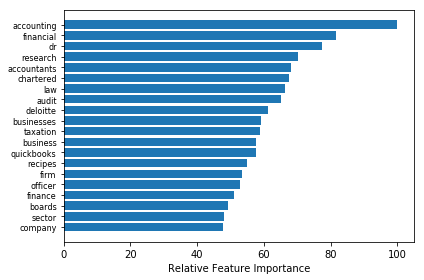

In [105]:
feature_importance_logreg(model1, X_bw_test, n_features=20)

Coefficients: 
 [0.69994471]


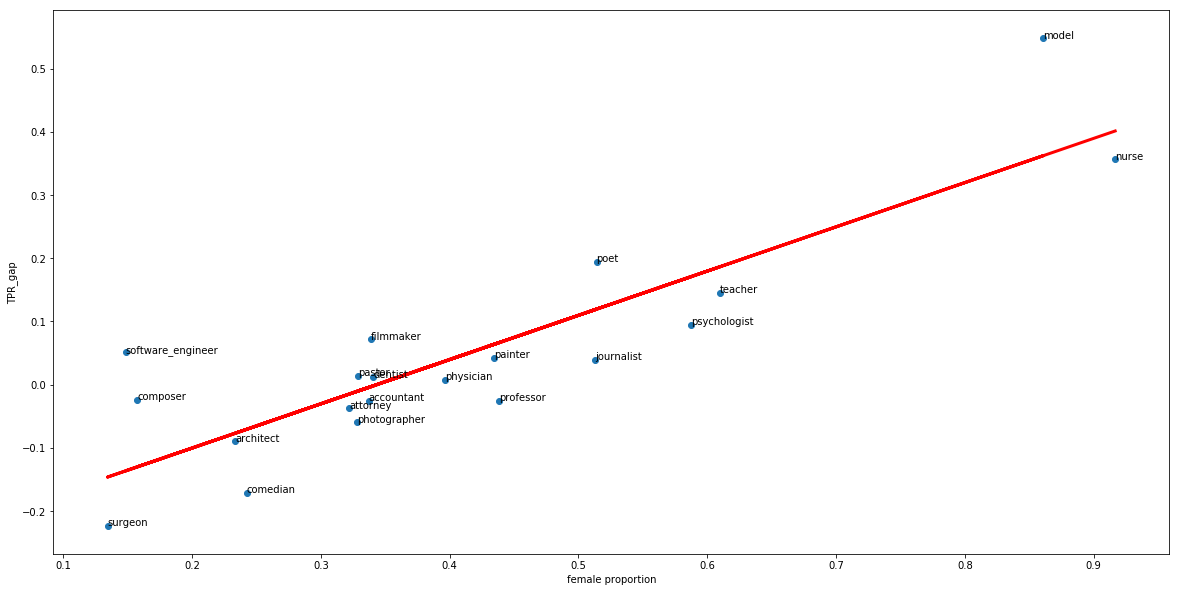

In [127]:
plot_TPRgap_femaleprop(preds1)

### Without gender information

In [109]:
model2 = LogisticRegression(penalty='l2')

model2.fit(X_bw_nogen_train, Titles_train)

/Users/hugues/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hugues/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [110]:
preds2 = model2.predict(X_bw_nogen_test)

In [111]:
print('Accuracy of classifier without gender informations on Title prediction:')
print(accuracy_score(Titles_test, preds2))

Accuracy of classifier without gender informations on Title prediction:
0.7568161024702653


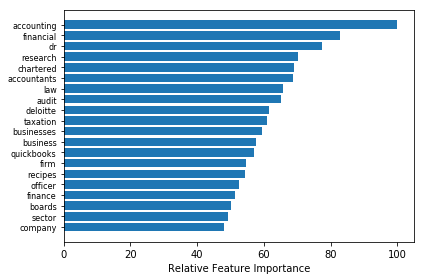

In [112]:
feature_importance_logreg(model2, X_bw_test, n_features=20)

There are not a lot of difference between the precisions of the models with and without gender information because as we can see in the feature importances, the model relies more on words that have less link with gender (such as 'accounting', 'financial'etc...).

Coefficients: 
 [0.40714297]


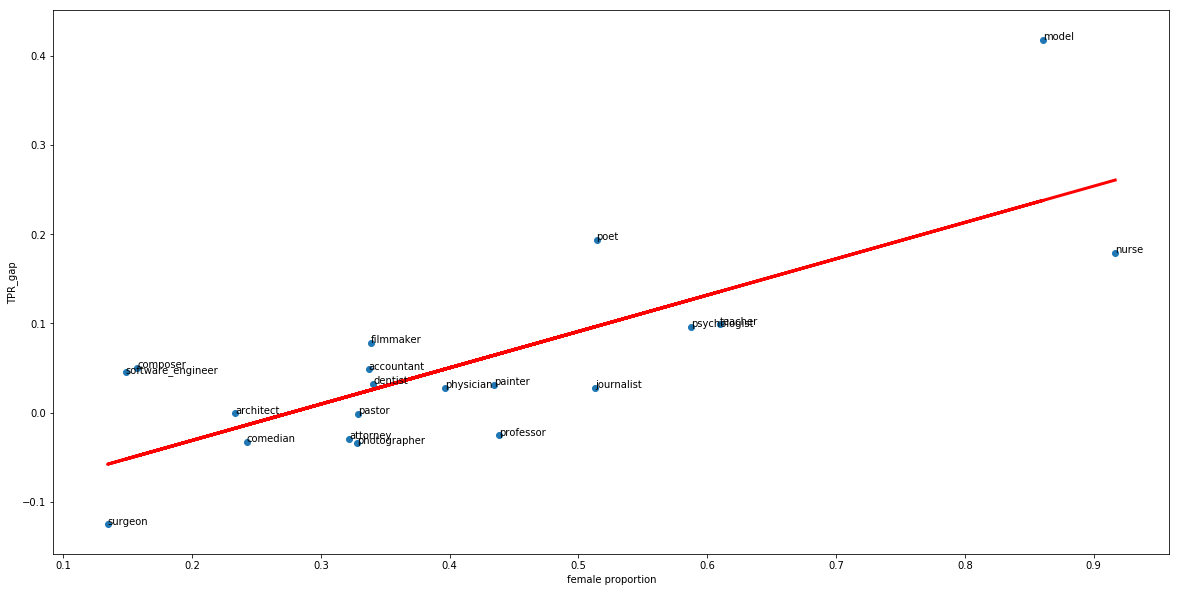

In [128]:
plot_TPRgap_femaleprop(preds2)

## Fasttext encoding

### With gender information

In [118]:
model3 = LogisticRegression(penalty='l2', solver='newton-cg')

model3.fit(X_fasttext_train, Titles_train)

/Users/hugues/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [119]:
preds3 = model3.predict(X_fasttext_test)

In [120]:
print('Accuracy of classifier with gender informations on Title prediction:')
print(accuracy_score(Titles_test, preds3))

Accuracy of classifier with gender informations on Title prediction:
0.6167429094236048


Coefficients: 
 [0.31780187]


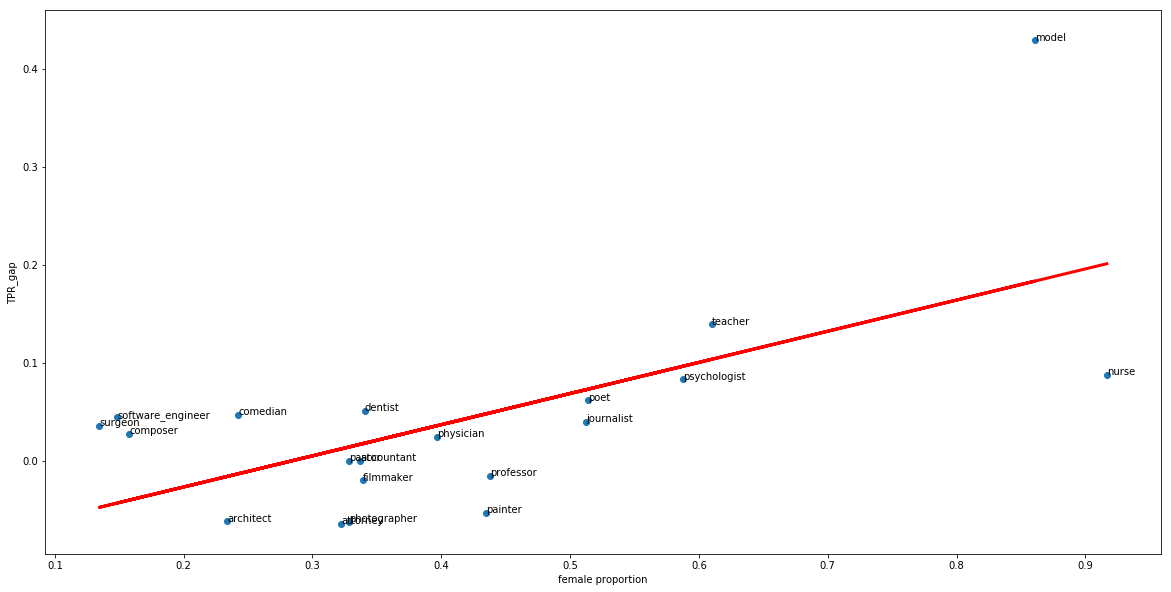

In [129]:
plot_TPRgap_femaleprop(preds3)

### Without gender information

In [122]:
model4 = LogisticRegression(penalty='l2', solver='newton-cg')

model4.fit(X_fasttext_nogen_train, Titles_train)

/Users/hugues/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [123]:
preds4 = model4.predict(X_fasttext_nogen_test)

In [124]:
print('Accuracy of classifier without gender informations on Title prediction:')
print(accuracy_score(Titles_test, preds4))

Accuracy of classifier without gender informations on Title prediction:
0.6175663311985361


Coefficients: 
 [0.1938985]


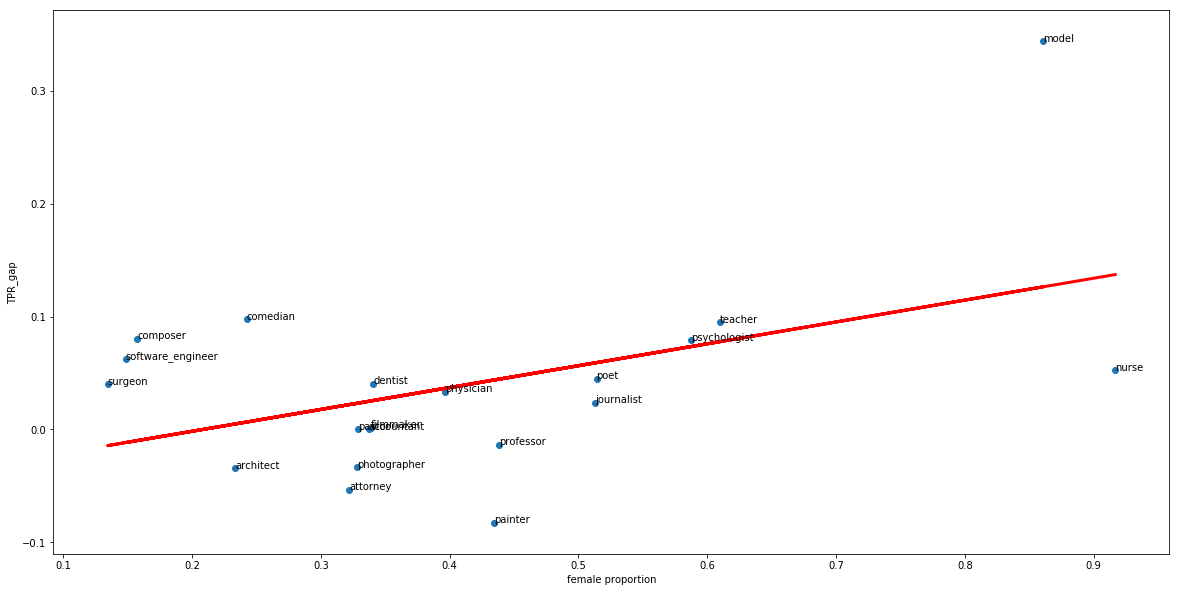

In [130]:
plot_TPRgap_femaleprop(preds4)

We find the kind of linear relation described in the paper: for a given title, the higher the female_proportion, the higher the TPR gender gap.

Moreover, we can see that the linear coefficient is higher when we do not remove pronouns from the biographies. So the higher the gender information, the stronger the relation between TPR_gap and female proportion. 